In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import seaborn as sns

In [45]:
#convert data to right format dataframe - must be in long format
student_list = range(100)
df_exams_results = \
pd.read_csv('/home/janice/Downloads/exams_results.csv', \
            delimiter = ',', names = student_list)
df_exams_results = df_exams_results.transpose()
df_exams_results['id']= df_exams_results.index
df_exams_results['first'] = [float(line) for line in df_exams_results[0]]
df_exams_results['second'] = [float(line) for line in df_exams_results[1]]
df_exams_results['status'] = df_exams_results[2]
df_1 = pd.melt(df_exams_results, id_vars= ['id'], value_vars = 'first')
df_2 = pd.melt(df_exams_results, id_vars= ['id'], value_vars = 'second')
df_status = pd.melt(df_exams_results, id_vars= ['id'], value_vars = 'status')
df_1and2 = df_1.merge(df_2, on = 'id')
df_value_status = df_1and2.merge(df_status, on = 'id')
df_value_ = df_value_status[['id', 'value_x', 'value_y', 'value']]
df_value_status_1 = df_value_[['id', 'value_x', 'value']]
df_value_status_2 = df_value_[['id', 'value_y', 'value']]
df_value_status_1.rename(columns = {'value_x':'score'}, inplace = True)
df_value_status_2.rename(columns = {'value_y':'score'}, inplace = True)
df_long = pd.concat([df_value_status_1, df_value_status_2])
df_value_.rename(columns = {'value_x':'first_score', 'value_y':'second_score'}, inplace = True)
dummy = pd.get_dummies(df_value_['value'])
dummy['id'] = dummy.index
dummy.rename(columns = {'ACCEPTED': 'status'}, inplace = True)
df_value_ = df_value_.merge(dummy, on = 'id')
df_value_ = df_value_[['id', 'first_score', 'second_score', 'status']]

/home/janice/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [46]:
df_value_to_tuple = df_value_[['first_score', 'second_score', 'status']] #convert X and y into a list of tuples
records = df_value_to_tuple.to_records(index = False)
data = list(records)
print(data)

[(34.6, 78., 0), (30.3, 43.9, 0), (35.8, 72.9, 0), (60.2, 86.3, 1), (79., 75.3, 1), (45.1, 56.3, 0), (61.1, 96.5, 1), (75., 46.6, 1), (76.1, 87.4, 1), (84.4, 43.5, 1), (95.9, 38.2, 0), (75., 30.6, 0), (82.3, 76.5, 1), (69.4, 97.7, 1), (39.5, 76., 0), (54., 89.2, 1), (69.1, 52.7, 1), (67.9, 46.7, 0), (70.7, 92.9, 1), (77., 47.6, 1), (67.4, 42.8, 0), (89.7, 65.8, 1), (50.5, 48.9, 0), (34.2, 44.2, 0), (77.9, 69., 1), (62.3, 70., 1), (80.2, 44.8, 1), (93.1, 38.8, 0), (61.8, 50.3, 0), (38.8, 65., 0), (61.4, 72.8, 1), (85.4, 57.1, 1), (52.1, 63.1, 0), (52., 69.4, 1), (40.2, 71.2, 0), (54.6, 52.2, 0), (33.9, 98.9, 0), (64.2, 80.9, 1), (74.8, 41.6, 0), (34.2, 75.2, 0), (83.9, 56.3, 1), (51.5, 46.9, 0), (94.4, 65.6, 1), (82.4, 40.6, 0), (51., 45.8, 0), (62.2, 52.1, 0), (77.2, 70.5, 1), (97.8, 86.7, 1), (62.1, 96.8, 1), (91.6, 88.7, 1), (79.9, 74.2, 1), (99.3, 61., 1), (90.5, 43.4, 1), (34.5, 60.4, 0), (50.3, 49.8, 0), (49.6, 59.8, 0), (97.6, 68.9, 1), (32.6, 95.6, 0), (74.2, 69.8, 1), (71.8, 78

Text(0.5, 1.0, 'exam results')

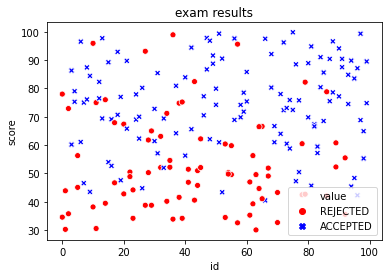

In [47]:
#this plot shows test scores as a function of student id, and the colors/markers indicate which students
#have been accepted or rejected.  However, in this simple plot there is no distinction between first and
#second score.

#plot data in seaboarn
sns.scatterplot(data = df_long, x = 'id', \
                y = 'score', hue = 'value', palette = ['red', 'blue'], \
                markers = True, style = 'value')
plt.title('exam results')

In [105]:
#we want to know which scores are accepted and which are rejected.
#we have three variables: x1, which is the first score; and x2, which is the second score. 

#Z calculation(the weighted sum calculated from matrix X)
def calc_z(x1, x2, theta):
    X = np.array(x1, x2)
    z = (theta.T* X)[0][0][0]
    return z
    
import math

#Sigmoid function applies the sigmoid transform to a variable x, which can be a vector or matrix  
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig
    
#Hypothesis function h maps yhat - described as "a" in some places.
#Hypothesis function is the transform g(theta.t dot Z), where Z is calculated from matrix X. 
#g(z) is the sigmoid transform of Z.
#theta.T is the transformed matrix of thetas for all X = x1, x2, ....  
def h(x1, x2, theta):
    X = np.array(x1, x2)
    g = (theta.T*calc_z(x1, x2, theta))[0][0][0]    
    return sigmoid(g)

#update cost (dJ/dtheta = (A-y)*X) for each iteration
def j_prime_theta(data, theta, order_of_regression, i):
    result = 0 
    m = len(data)
    for x1,x2, y in data:
        X = np.array(x1,x2)
        X = update_features(order_of_regression)
        result += ((h(X, theta)-y)*X[i])
    print(result)
    return result

def update_features(x1, x2, order_of_regression):
    X = np.array(x1,x2)
    features = [1]
    for i in range(order_of_regression):
        features.append(math.pow(X, i+1))
    return np.atleast_3d(features).T
                   
#cost function
def j(data, theta, order_of_regression):
    cost = 0
    m = len(data)
    for x1, x2, y in data:
        X = np.array(x1,x2)
        X = update_features(x1, x2, order_of_regression)
        try:
            cost += -y*math.log(h(x1, x2, theta))-(1-y)*math.log(1-h(x1, x2, theta)) 
        except:
            pass
    return (1/m) * cost
                   
#simultaneous update using step size alpha
def update_theta(data, alpha, theta, order_of_regression):
    temp = []
    for i in range(order_of_regression+1):
        temp.append(theta[i] - alpha * j_prime_theta(data, theta, order_of_regression, i))
        theta = np.array(temp)
        return theta

def gradient_descent(data, alpha, tolerance, theta = [], order_of_regression = 1):
    if len(theta) == 0:
        theta = np.atleast_3d(np.random.random(order_of_regression)*100).T
    prev_j =10000
    curr_j = j(data, theta, order_of_regression)
    cost_history = []
    theta_history = [] 
    counter = 0
    while(abs(curr_j - prev_j) > tolerance):
        try:
            cost_history.append(curr_j)
            theta_history.append(theta)
            theta = reg_update_theta(data, alpha, theta, order_of_regression)
            prev_j = curr_j
            curr_j = reg_j(data, theta, order_of_regression)
            counter +=1
        except:
            break
    
    return theta, theta_history
                   
    

theta1and2, history = gradient_descent(data, alpha = 0.01, tolerance = 0.001, theta = [], order_of_regression = 1)
print(theta1and2)

#find a way to print each one within the loop to transfer to the graph!  

[[[99.76924242]]]


In [107]:
def calc_z_results(data, theta):
    for x1,x2, y in data:
        X = np.array(x1,x2)
        z = (theta.T* X)[0][0][0]
        g = (theta.T*z)[0][0][0]    
        #print(sigmoid(g))
        
calc_z_results(data, theta1and2)



In [115]:
#exercise 2

df_qa = pd.read_csv('/home/janice/Downloads/quallity_assurance.csv', delimiter = '\t')
df_qa.rename(columns = {"X1": "first_test", "X2": "second_test"}, inplace = True)


Text(0.5, 1.0, 'quality assurance')

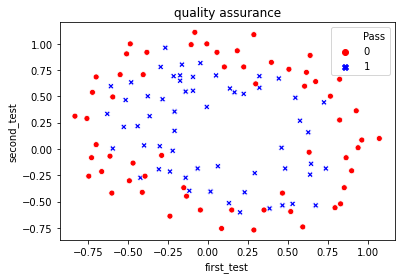

In [116]:
sns.scatterplot(data = df_qa, x = "first_test", \
                y = 'second_test', hue = 'Pass', palette = ['red', 'blue'], \
                markers = True, style = 'Pass')
plt.title('quality assurance')


None
